In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch.nn.functional as F

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [3]:
mat = scipy.io.loadmat('notMNIST_small.mat')
mat.keys()


dict_keys(['__header__', '__version__', '__globals__', 'images', 'labels'])

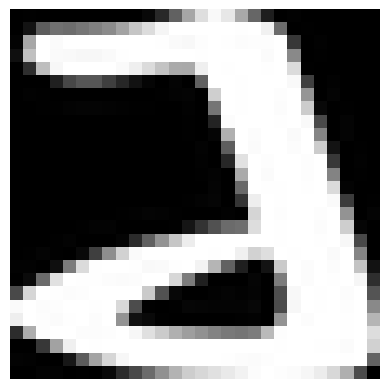

In [4]:
mat['images'].shape

plt.imshow(mat['images'][:, :, 1], cmap='gray')
plt.axis('off')
plt.show()

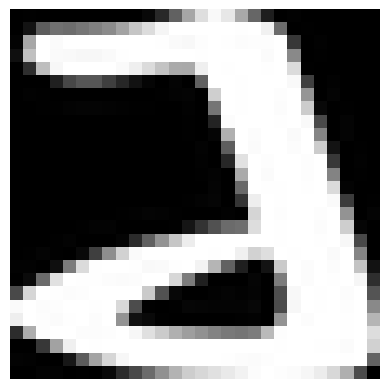

(18724, 28, 28)

In [5]:
new_img = np.random.rand(18724, 28, 28)
for index in range(mat['images'].shape[2]):
    new_img[index] = mat['images'][:,:,index]

plt.imshow(new_img[1, :, :], cmap='gray')
plt.axis('off')
plt.show()

new_img.shape

In [6]:
indices = np.arange(18724)
np.random.shuffle(indices)
labels = np.array(mat['labels'])


shuffled_images = new_img[indices]
shuffled_labels = labels[indices]

In [7]:
x_train_img = np.array(shuffled_images[0:11234, :,:])
x_test_img = np.array(shuffled_images[11235:18724, :,:])
y_train_label = np.array(shuffled_labels[0:11234])
y_test_label =np.array(shuffled_labels[11235:18724])

x_train_img.shape

(11234, 28, 28)

In [8]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):

        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

 
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [9]:
test_images = x_test_img
test_labels = y_test_label

test_dataset = CustomDataset(test_images, test_labels)

test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [10]:
from torch.utils.data import DataLoader

images = x_train_img
labels = y_train_label

custom_dataset = CustomDataset(images, labels)

data_loader = DataLoader(dataset=custom_dataset, batch_size=32, shuffle=True)


In [11]:
class SimpleCNN_x(nn.Module):
    def __init__(self, num_classes=10):  
        super(SimpleCNN_x, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(3136, 128)  
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = self.pool(x2)
        x4 = self.pool(F.relu(self.conv3(x3)))
        x5 = x4.view(x4.size(0), -1)  
        x6 = F.relu(self.fc1(x5))
        out = self.fc2(x6)
        return x1, x2, out


C:\Users\denis\AppData\Local\Temp\ipykernel_10972\691292828.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Epoch 1/25, Step 100/352, Loss: 0.22280
Epoch 1/25, Step 200/352, Loss: 0.29938
Epoch 1/25, Step 300/352, Loss: 0.26895
Epoch 2/25, Step 100/352, Loss: 0.40251
Epoch 2/25, Step 200/352, Loss: 0.25829
Epoch 2/25, Step 300/352, Loss: 0.24424
Epoch 3/25, Step 100/352, Loss: 0.11855
Epoch 3/25, Step 200/352, Loss: 0.24071
Epoch 3/25, Step 300/352, Loss: 0.13892
Epoch 4/25, Step 100/352, Loss: 0.03229
Epoch 4/25, Step 200/352, Loss: 0.00628
Epoch 4/25, Step 300/352, Loss: 0.02257
Epoch 5/25, Step 100/352, Loss: 0.00025
Epoch 5/25, Step 200/352, Loss: 0.31258
Epoch 5/25, Step 300/352, Loss: 0.00720
Epoch 6/25, Step 100/352, Loss: 0.00966
Epoch 6/25, Step 200/352, Loss: 0.09252
Epoch 6/25, Step 300/352, Loss: 0.00062
Epoch 7/25, Step 100/352, Loss: 0.16615
Epoch 7/25, Step 200/352, Loss: 0.00520
Epoch 7/25, Step 300/352, Loss: 0.01680
Epoch 8/25, Step 100/352, Loss: 0.04209
Epoch 8/25, Step 200/352, Loss: 0.09774
Epoch 8/25, Step 300/352, Loss: 0.02942
Epoch 9/25, Step 100/352, Loss: 0.03144


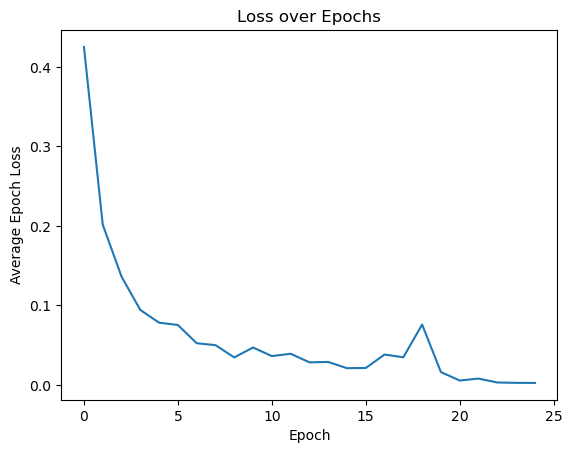

In [12]:
mdlx = SimpleCNN_x(num_classes=10) 
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(mdlx.parameters(), lr=0.001) 

mdlx = mdlx.to(device)

num_epochs = 25  
epoch_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0

    for i, (images, labels) in enumerate(data_loader):
        images, labels = images.to(device), labels.to(device)
        images = images.unsqueeze(1)
        
        x1, x2, outputs = mdlx(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        num_batches += 1

        if (i+1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(data_loader)}, Loss: {loss.item():.5f}')

    epoch_loss /= num_batches
    epoch_losses.append(epoch_loss)

plt.plot(epoch_losses)
plt.ylabel('Average Epoch Loss')
plt.xlabel('Epoch')
plt.title('Loss over Epochs')
plt.show()


In [13]:
def test_model_x(mdlx, test_loader):
    mdlx = mdlx.to(device)
    
    mdlx.eval() 
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            images = images.unsqueeze(1)  
            x1, x2, outputs = mdlx(images)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')


test_model_x(mdlx, test_loader)

C:\Users\denis\AppData\Local\Temp\ipykernel_10972\691292828.py:23: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label = torch.tensor(label, dtype=torch.long)


Accuracy: 94.23%


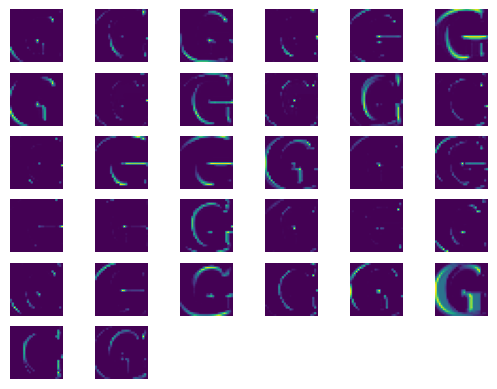

In [20]:
x1, x2, out = mdlx(images)


feature_maps = x1[1].detach().cpu().numpy()  


for i, feature_map in enumerate(feature_maps):
    plt.subplot(6, 6, i+1)
    plt.imshow(feature_map, cmap='viridis')
    plt.axis('off')

plt.show()

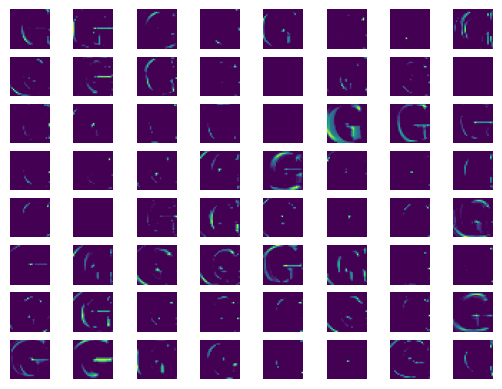

In [21]:
feature_maps = x2[1].detach().cpu().numpy()  


for i, feature_map in enumerate(feature_maps):
    plt.subplot(8, 8, i+1)
    plt.imshow(feature_map, cmap='viridis')
    plt.axis('off')

plt.show()